<a href="https://www.kaggle.com/desmondrn/motorbikes-analysis-per-station-training?scriptVersionId=83948721" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%reset -f

In [2]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==0.24.1

In [3]:
%%capture

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import joblib

import tensorflow as tf
mae = tf.keras.losses.MeanAbsoluteError()    ## The loss for this task
_ = mae([1], [2])                            ## Trick to initialize tensorflow here !

import os


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

# Objective
The goal of this notebook is to analyse the `motorbikes2021` dataset and identify the best features and best per-station machine learning algorithms to use in the next phases of the competition. Our task is to predict the number of bikes at a station in 3h time.

# Load data for a few stations and analyse

**Which features are the most important when it comes to learning the number of bikes at a station?** The answer will focus on a particular station (identified by its id `STATION_ID`). Now some features were engineered and provided to us in the dataset. These are described by `short`, `short_temp`, `full`, `full_temp`, `short_full`, and `short_full_temp`. Change the variable `FEATURE_SET` to either of these values to get different results.

In [4]:
INPUT_DIR = '/kaggle/input/morebikes2021'

STATION_ID = 252                  ## Change here to train models for other stations
FEATURE_SET = 'short_full_temp'   ## Change here to train with different features 

SHUFFLE_SAMPLES = True           ## Change here to shuffle the dataset before spliting
TRAIN_SIZE = 0.80                ## Change the train proportion here

os.listdir(INPUT_DIR)

['example_leaderboard_submission.csv', 'Models', 'test.csv', 'Train']

In [5]:
def get_train_path(station_id):
    return INPUT_DIR+'/Train/Train/station_'+str(station_id)+'_deploy.csv'

df = pd.read_csv(get_train_path(STATION_ID))

df.head()

,station,latitude,longitude,numDocks,timestamp,year,month,day,hour,weekday,...,temperature.C,relHumidity.HR,airPressure.mb,precipitation.l.m2,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
0,252,39.484577,-0.401273,15,1.412114e+09,2014,10,1,0,Wednesday,...,21.3,85.0,855.3,0.0,NaN,NaN,NaN,NaN,NaN,6.0
1,252,39.484577,-0.401273,15,1.412118e+09,2014,10,1,1,Wednesday,...,21.1,86.0,1000.6,0.0,NaN,NaN,NaN,NaN,NaN,6.0
2,252,39.484577,-0.401273,15,1.412122e+09,2014,10,1,2,Wednesday,...,20.9,86.0,880.6,0.0,NaN,NaN,NaN,NaN,NaN,5.0
3,252,39.484577,-0.401273,15,1.412125e+09,2014,10,1,3,Wednesday,...,20.4,88.0,859.8,0.0,6.0,NaN,NaN,NaN,NaN,5.0
4,252,39.484577,-0.401273,15,1.412129e+09,2014,10,1,4,Wednesday,...,20.3,87.0,898.1,0.0,6.0,NaN,NaN,NaN,NaN,5.0


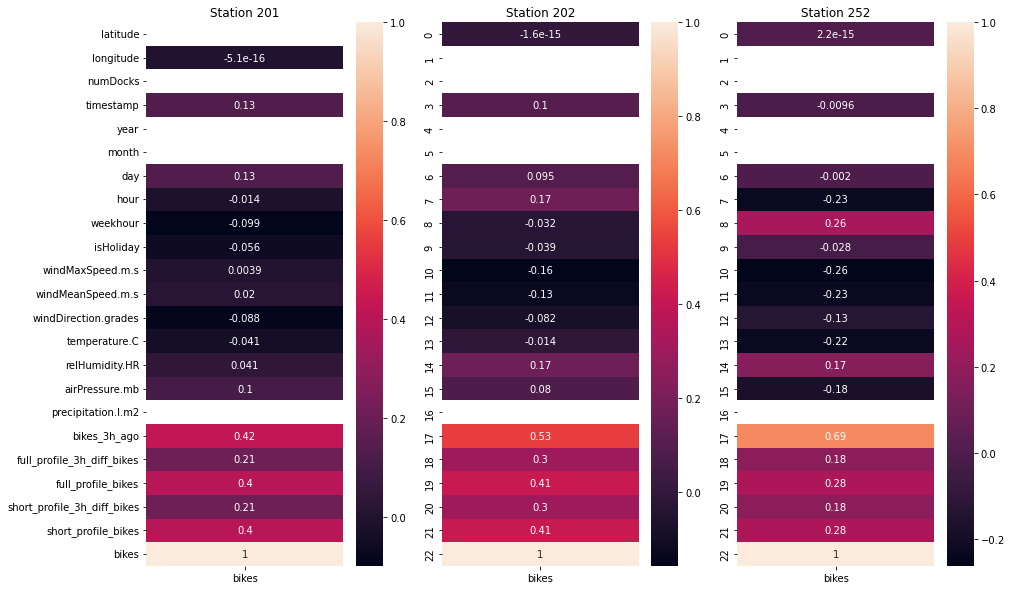

In [6]:
def plot_corr_map(station_id, ax, labels=True):
    df = pd.read_csv(get_train_path(station_id))
    df = df.drop(['station', 'weekday'], axis=1)

    s = df.corrwith(df['bikes'])
    if not labels: s = np.array(s)
    df = pd.DataFrame({'bikes':s})

    ax.set_title('Station '+str(station_id))
    sns.heatmap(df, annot=True, ax=ax)
    
fig, ax = plt.subplots(1, 3, figsize=(15,10)) 

## Investigate correlation between features and target variable for specific stations
plot_corr_map(201, ax=ax[0])
plot_corr_map(202, ax=ax[1], labels=False)
plot_corr_map(STATION_ID, ax=ax[2], labels=False)

Analysing the correlation between predictor variables and our target variable for three seperate stations indicate that weather and timepoint features can be important for training. On the other hand, features relating to the station are going to be dropped. The same goes for non-numeric features like `weekday` or constant features like `year` or `month`. In order to use all these interresting features for training, the `FEATURE_SET` variable above can be set `all`.

In [7]:
def preprocess(df):
    df = df.drop(['weekday', 'latitude', 'longitude','year', 'month'], axis=1)
#     df = df.drop(['numDocks'], axis=1)
    df = df.drop(['station'], axis=1)
    df['timestamp'] = (df['timestamp'] - 1412114400) / 3600
    return df

def get_peters_features():
    """
    Features suggested by the competition
    """
    short = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes']
    short_temp = short + ['temperature.C']
    full = ['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    full_temp = full + ['temperature.C']
    short_full = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    short_full_temp = short_full + ['temperature.C']
    
    if FEATURE_SET=='short':
        return short
    elif FEATURE_SET=='short_temp':
        return short_temp
    elif FEATURE_SET=='full':
        return full
    elif FEATURE_SET=='full_temp':
        return full_temp
    elif FEATURE_SET=='short_full':
        return short_full
    elif FEATURE_SET=='short_full_temp':
        return short_full_temp
    else:
        return 'all'

def select_peters_features(df):
    features_to_use = get_peters_features()
    if features_to_use == 'all':
        return df.dropna()
    else:
        if 'bikes' in list(df.columns):
            features_to_use += ['bikes']
        return df[features_to_use].dropna()

In [8]:
def make_learning_data(station_id):
    df = pd.read_csv(get_train_path(station_id))
    
    df = preprocess(df)
    if SHUFFLE_SAMPLES:
        df = df.sample(frac=1, random_state=12)

    df = select_peters_features(df)

    df_y = df['bikes']
    df_X = df.drop(['bikes'], axis=1)

    return np.array(df_X), np.array(df_y)

X, y = make_learning_data(STATION_ID)

In [9]:
""" Split the data between training and validation """
def split_dataset(X, y, train_size):
    dataset_size = len(X)
    assert dataset_size == len(y)
    assert dataset_size >= train_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    return (X_train, y_train), (X_val, y_val)

(X_train, y_train), (X_val, y_val) = split_dataset(X, y, int(TRAIN_SIZE*len(X)))

print("Train shapes:", X_train.shape, y_train.shape)
print("Val shapes:", X_val.shape, y_val.shape)

Train shapes: (457, 6) (457,)
Val shapes: (115, 6) (115,)


Afted imputing missing values, we've split the loaded data for training and validation while avoiding shuffling. We will train our models on 80% of the data (approximately 25 days) and evaluate the models on the remaining 6 last days of the month. The idea is that the model that performs best on this slightly drifted data is most likely to perform best on the more drifted testing data (for the next 3 months). Here, the 80/20% split is for demonstration purose; in production setting, we went for a 95/5% division to achieve better performance (see Phases 1, 2, and 3).

# Per-station trainings

We have identified several machine learning algorithms that can be interresting for our task. Each algorithm will be trained, tuned and stored for later comparison at the end of the notebook. Given the wide range of values our features can take, most algorithms will require a form of scaling before fitting, hence the widespread usage of `Pipleline` in what follow.

In [10]:
""" All models that will be trained and their scores """

potential_models = []

## Linear Regression

Given the nature of the variables, linear regression is the most intuitive choice here. We opted for Ridge regularization to avoid massive weights, while keeping as many features as possible (not setting weights to 0). We also considered using polynomial and interaction features (up to degree 3) which, depending on the initial set of features we chosed, improved the results.

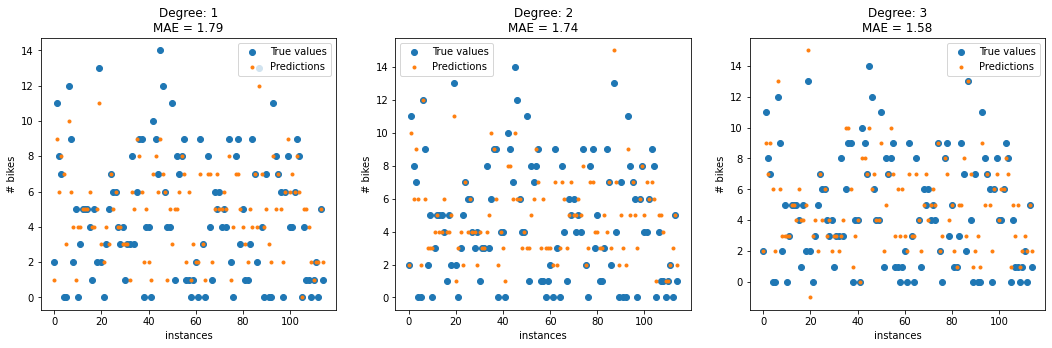

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import cross_val_score

degrees = [1, 2, 3]

plt.figure(figsize=(18, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    scaled_features = StandardScaler()
#     scaled_features = MinMaxScaler()
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
#     linear_regression = PoissonRegressor()
#     linear_regression = Lasso()
    linear_regression = Ridge()
    pipeline = Pipeline(
        [
            ("scaled_features", scaled_features),
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X_train, y_train)

    y_pred = np.rint(pipeline.predict(X_val))
    score = mae(y_val, y_pred).numpy()
    
    potential_models.append(('linear_reg_'+str(i+1), pipeline, score))

    plt.plot(y_val, "o", label="True values")
    plt.plot(y_pred, ".", label="Predictions")
    ax.set_xlabel("instances")
    plt.ylabel("# bikes")
    plt.legend(loc="best")
    plt.title("Degree: {}\nMAE = {:.2f}".format(degrees[i], score))

In [12]:
### See what the weights look like
potential_models[0][1].named_steps['linear_regression'].coef_

array([ 2.50644847,  0.46833421,  0.09366008,  0.46833421,  0.09366008,
       -0.09900921])

## k-Nearest Neighbors

Our task can also be viewed as a multiclass classification problem, whith exactly `numDocks+1` classes. The first algorithm we considered for this approach is the low-bias and high-variance k-Nearest Neighbors algorithm with `k=2`. Compared to other models, we found that kNN produces better results when the input data is not normalized.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=2)

KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

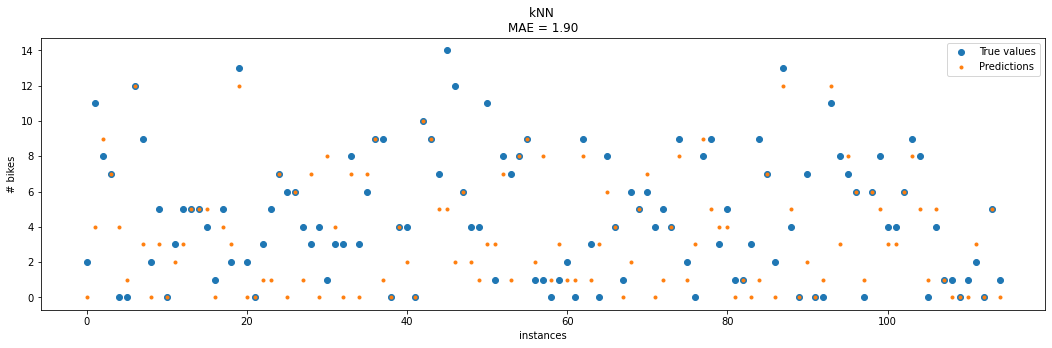

In [14]:
def plot_results(y_pred, title):
    fig, ax = plt.subplots(1, 1, figsize=(18, 5))

    plt.plot(y_val, "o", label="True values")
    ax.plot(y_pred, ".", label="Predictions")
    ax.set_xlabel("instances")
    ax.set_ylabel("# bikes")
    ax.legend(loc="best")
    ax.set_title(
        title+" \nMAE = {:.2f}".format(
            mae(y_val, y_pred).numpy()
        )
    )

y_pred = KNN.predict(X_val)

potential_models.append(('knn', KNN, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='kNN')

## Logistic regression

Logistic regression with multiple classes is not properly implemented on our version of scikit-learn (0.23), so we left it out !

In [15]:
# from sklearn.linear_model import LogisticRegressionCV

## LogReg = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', max_iter=400)
# LogReg = Pipeline([("minmax_scaler", MinMaxScaler()), 
#                    ("logistic_reg", LogisticRegressionCV(multi_class='ovr', solver='lbfgs', max_iter=200))])

# LogReg.fit(X_train, y_train)

In [16]:
# y_pred = LogReg.predict(X_val)
# potential_models.append(('logistic_reg', LogReg, mae(y_val, y_pred).numpy()))
# plot_results(y_pred, title='Logistic regression')

## Decision Tree

Another high-variance model we tested is decision trees. We placed no limits on the number of leafs nor minimum features required to split a node.  

In [17]:
from sklearn.tree import DecisionTreeClassifier

# DcTree = DecisionTreeClassifier(random_state=12)
DcTree = Pipeline([("minmax_scaler", MinMaxScaler()), ("decision_tree", DecisionTreeClassifier(random_state=12))])

DcTree.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('decision_tree', DecisionTreeClassifier(random_state=12))])

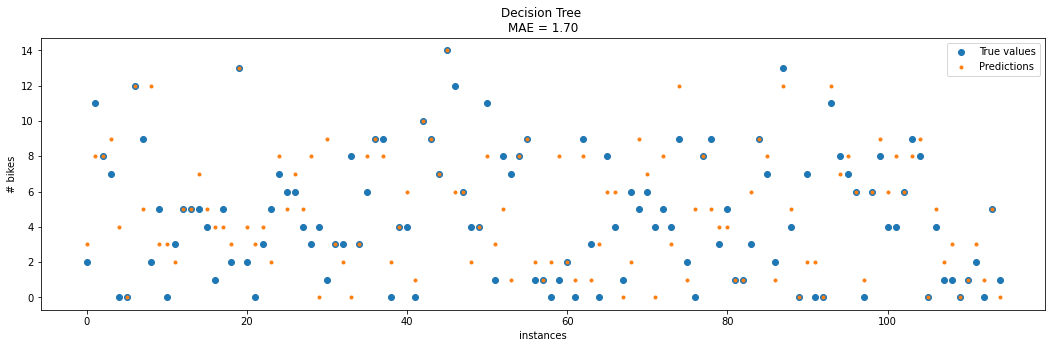

In [18]:
y_pred = DcTree.predict(X_val)

potential_models.append(('decision_tree', DcTree, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='Decision Tree')

## Random Forest

In an attempt to reduce the variance and improve results obtianed from decision trees, we tested random forests.

In [19]:
from sklearn.ensemble import RandomForestClassifier

# RdFor = RandomForestClassifier(n_estimators=300, max_leaf_nodes=None, n_jobs=-1, random_state=12)
RdFor = Pipeline([("minmax_scaler", MinMaxScaler()), ("random_forest", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=12))])

RdFor.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('random_forest',
                 RandomForestClassifier(n_jobs=-1, random_state=12))])

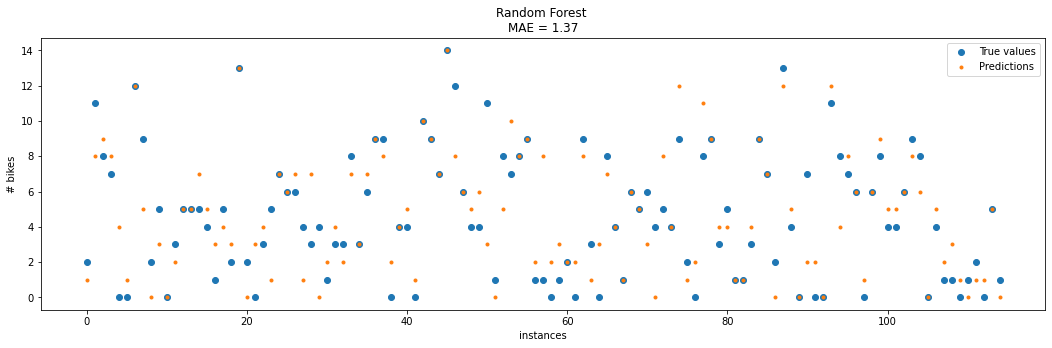

In [20]:
y_pred = RdFor.predict(X_val)

potential_models.append(('random_forest', RdFor, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='Random Forest')

## SVM - One vs. Rest

Another algorithm we investigated for classification is Support Vector Machine. Since this is an inherently binary classification algorithm, we tested two techniques for multiclass classification: 
- the efficient [One vs. Rest](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html),
- the more costly [One vs. One](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html).

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

# SVM1 = OneVsRestClassifier(LinearSVC(random_state=12))
SVM1 = Pipeline([("minmax_scaler", MinMaxScaler()), ("svm_ovr", OneVsRestClassifier(LinearSVC(random_state=12)))])

SVM1.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('svm_ovr',
                 OneVsRestClassifier(estimator=LinearSVC(random_state=12)))])

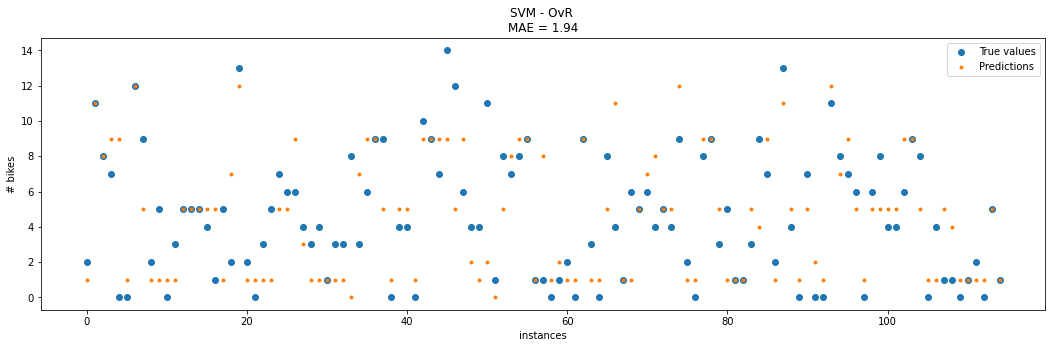

In [22]:
y_pred = SVM1.predict(X_val)

potential_models.append(('svm_ovr', SVM1, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='SVM - OvR')

## SVM - One vs. One

In [23]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# SVM2 = OneVsOneClassifier(SVC(random_state=12))
SVM2 = Pipeline([("minmax_scaler", MinMaxScaler()), ("svm_ovo", OneVsOneClassifier(SVC(random_state=12)))])

SVM2.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('svm_ovo',
                 OneVsOneClassifier(estimator=SVC(random_state=12)))])

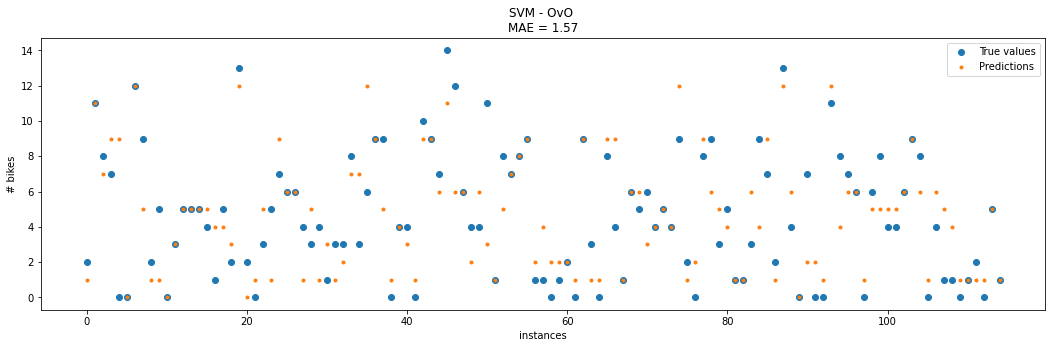

In [24]:
y_pred = SVM2.predict(X_val)

potential_models.append(('svm_ovo', SVM2, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='SVM - OvO')

## Poisson regression

An interresting remark is that the number of features at a station (sometimes) appears to follows a Poisson distribution, with the station most often empty than full. This justifies the the Poisson regression in what follows.

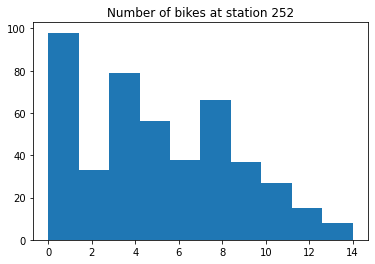

In [25]:
plt.hist(y_train)
plt.title('Number of bikes at station '+str(STATION_ID));

In [26]:
from sklearn.linear_model import PoissonRegressor

# Poisreg = PoissonRegressor()
Poisreg = Pipeline([("minmax_scaler", MinMaxScaler()), ("pois_reg", PoissonRegressor())])

Poisreg.fit(X_train, y_train)

Pipeline(steps=[('minmax_scaler', MinMaxScaler()),
                ('pois_reg', PoissonRegressor())])

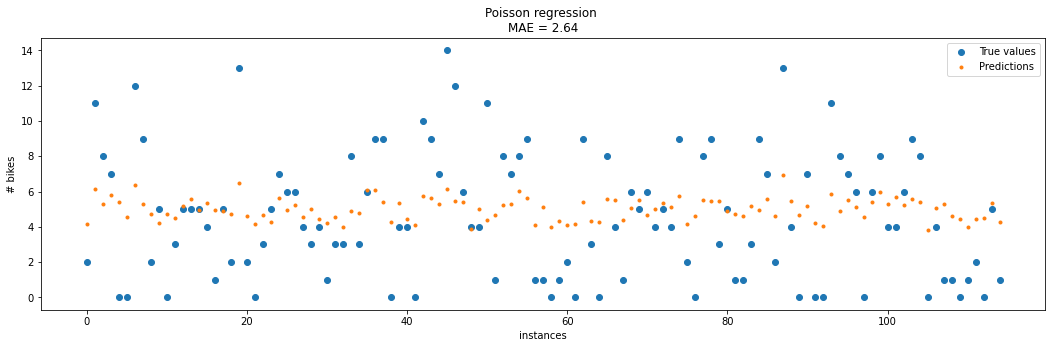

In [27]:
y_pred = Poisreg.predict(X_val)

potential_models.append(('poisson_reg', Poisreg, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='Poisson regression')

## Neural Network

The final model we tested is a 2-layered fully connected neural network. Even with untuned hyper-parameters and blattant happening, we found that neural networks outperform other models for most stations in the dataset. However, in the spirit of fairness, we will not consider neural networks for the following phases of this work.

In [28]:
""" Define the model  """
KerasNet = tf.keras.Sequential([

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(4096, activation='relu'),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Flatten(),

#         tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(1024, activation='relu'),
#         tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Dense(28, activation='softmax')        
    
#         tf.keras.layers.Dense(28, activation='relu'),
#         tf.keras.layers.Dense(1)                    
                    
      ])

## Model architecture test with a batch size of 2
KerasNet(X_train)

KerasNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (457, 6)                  0         
_________________________________________________________________
dense (Dense)                (457, 4096)               28672     
_________________________________________________________________
dense_1 (Dense)              (457, 1024)               4195328   
_________________________________________________________________
dense_2 (Dense)              (457, 28)                 28700     
Total params: 4,252,700
Trainable params: 4,252,700
Non-trainable params: 0
_________________________________________________________________


In [29]:
""" Compile the model  """
KerasNet.compile(
#     loss=mae,    
    loss=tf.losses.sparse_categorical_crossentropy,
    optimizer=tf.optimizers.Adam(1e-4),
    metrics=[tf.metrics.sparse_categorical_accuracy])

In [30]:
""" Train the model (probably overfits)  """

history = KerasNet.fit(
      X_train,
      y_train,
      batch_size=60,
      epochs=100,
      verbose=0,
#       steps_per_epoch=100,
      validation_data=(X_val, y_val),
)

2021-12-30 14:21:37.729853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


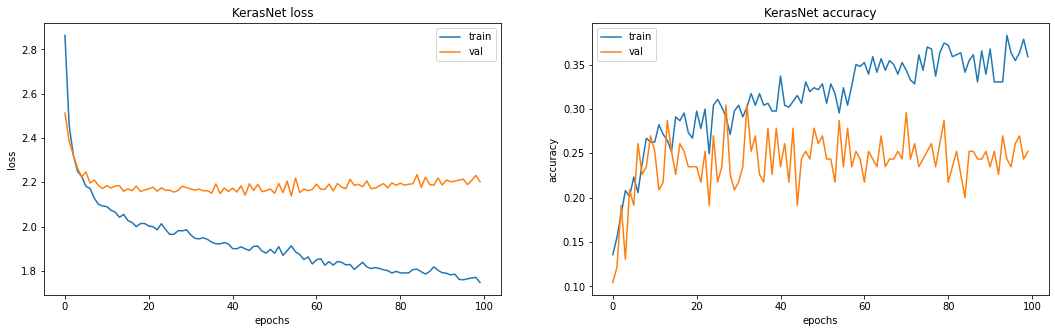

In [31]:
""" Visualize crossentropy loss and accuracy """

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(18, 5))

# summarize history for accuracy
ax1.plot(history.history['sparse_categorical_accuracy'])
ax1.plot(history.history['val_sparse_categorical_accuracy'])
ax1.set_title('KerasNet accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')
ax1.legend(['train', 'val'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('KerasNet loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.legend(['train', 'val'], loc='upper right');

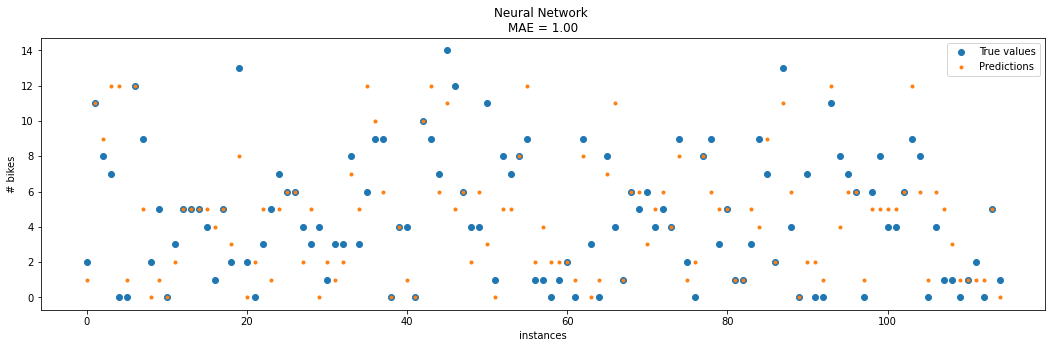

In [32]:
""" Make a few predictions """
# Evaluate the model on the test data 
# results = KerasNet.evaluate(X_val[:,:,np.newaxis], y_val, batch_size=12)
# print("Results (loss and accuracy) on Station "+str(201)+" test dataset:", results)

# Generate predictions on new data
y_hat_pred_proba = KerasNet.predict(X_val)
y_pred = tf.cast(tf.argmax(y_hat_pred_proba, axis=1),tf.int32)

# Predictions for regression scenario
# y_pred = KerasNet.predict(X_val)

## Save the model
potential_models.append(('neural_net', KerasNet, mae(y_val, y_pred).numpy()))

plot_results(y_pred, title='Neural Network')

# Sort the models and pick the best

Here, we compare the models and plot the result ar a bar chart. As we stated before, only the best model will be selected to make predictions for the corresponding station in the following phases.

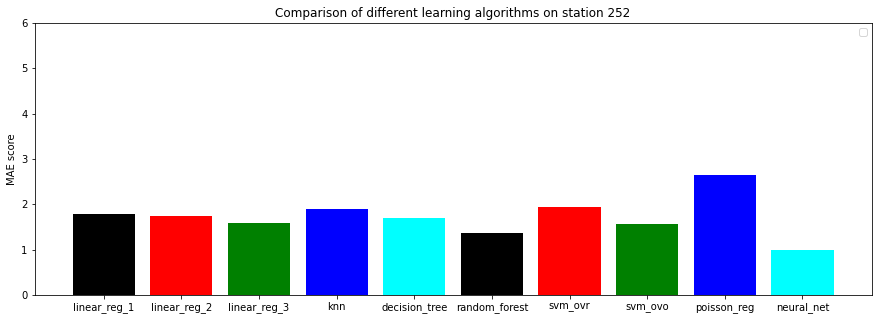

In [33]:
# potential_models

labels = []
y_plot = []
for mod in potential_models:
    labels.append(mod[0])
    y_plot.append(mod[2])
    
x_plot = np.arange(len(y_plot))
fig, ax = plt.subplots(1, 1, figsize=(15,5)) 
plt.bar(x_plot, height=y_plot, color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xticks(ticks=x_plot, labels=labels)
plt.ylim((0, 6))
plt.ylabel("MAE score")
plt.title("Comparison of different learning algorithms on station "+str(STATION_ID))
plt.legend()

In [34]:
potential_models = sorted(potential_models, key=lambda el:el[2])

## Save the best model
if potential_models[0][0] != 'neural_net':
    save_name = str(STATION_ID)+'_'+potential_models[0][0]+'.pkl'
#     joblib.dump(potential_models[0][1], save_name)
else:
    save_name = str(STATION_ID)+'_'+potential_models[0][0]+'.h5'
#     potential_models[0][1].save(save_name)

## The best model is
(save_name, potential_models[0][1], potential_models[0][2])

('252_neural_net.h5',
 1)